<a href="https://colab.research.google.com/github/heebonpark/git-test/blob/main/16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import glob
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import drive

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 압축 파일 경로 및 압축 해제 경로 설정
zip_file_path = '/content/drive/My Drive/회사업무/인허가_0815/LOCALDATA_YESTERDAY_CSV 2.zip'
extract_folder = '/content/extracted_data'

# 폴더가 없으면 생성
os.makedirs(extract_folder, exist_ok=True)

# 압축 해제
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
except FileNotFoundError:
    print(f"Error: Specified zip file '{zip_file_path}' not found. Please check the path.")
    exit(1)

# 압축 해제된 폴더에서 모든 CSV 파일 목록 가져오기
all_files = glob.glob(os.path.join(extract_folder, "**/*.csv"), recursive=True)

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []
else:
    # 각 파일을 읽어서 하나의 DataFrame으로 병합
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)
    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자',
                    '인허가취소', '영업상태명', '폐업일자', '휴업시작일', '휴업종료일', '재개업일자',
                    '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

# Check if filtered_df is empty before saving to CSV
output_csv_path = None
if filtered_df.empty:
    print("Error: The filtered DataFrame is empty. No CSV file will be created.")
else:
    # CSV 파일로 저장
    output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
    os.makedirs(output_dir, exist_ok=True)
    output_csv_path = os.path.join(output_dir, '15일_일일(서울,경기,강원).csv')
    filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

# 엑셀 파일 경로 설정
file1_path = os.path.join('/content/drive/My Drive/회사업무/행안부자료/0801', '1.영업구역별_주소현행화0725.xlsx')

# 파일 경로 확인
if not os.path.exists(file1_path):
    raise FileNotFoundError(f"{file1_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")
if output_csv_path is None or not os.path.exists(output_csv_path):
    raise FileNotFoundError(f"{output_csv_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 엑셀 파일 읽기
df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(output_csv_path, encoding='cp949')

# 주소 정규화 함수
def normalize_address(address):
    if pd.isna(address):
        return address
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    if '*' in address:
        return None
    return address

# 주소 정규화
df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

# TF-IDF 벡터화 및 주소 매핑
vectorizer = TfidfVectorizer().fit(df1['full_address'])
tfidf_matrix = vectorizer.transform(df1['full_address'])

def get_best_match(address, tfidf_matrix, vectorizer, choices, threshold=0.7):
    if pd.isna(address):
        return None
    query_vec = vectorizer.transform([address])
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    best_match_index = cosine_similarities.argmax()
    best_match_score = cosine_similarities[best_match_index]
    if best_match_score >= threshold:
        return choices[best_match_index]
    return None

choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, tfidf_matrix, vectorizer, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, tfidf_matrix, vectorizer, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

# 매핑되지 않은 항목 확인
unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

# 평수 계산 및 데이터 정리
merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수',
                   '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거 및 정렬
df_filtered.drop_duplicates(inplace=True)
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# '중앙' 지사 및 'Unknown' 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != '중앙') &
                                        (df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# 관리지사별 폴더 생성 및 SP담당자별 파일 저장
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    # 관리지사별로 SP담당자별로 저장
    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0815일.xlsx')

        with pd.ExcelWriter(sp_file_path, engine='openpyxl') as writer:
            df_sp.to_excel(writer, index=False, sheet_name='데이터')

        # PDF 시각화 생성
        pdf_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0815일.pdf')

        with PdfPages(pdf_file_path) as pdf:
            # SP담당자별 영업상태명 집계현황 그래프 생성
            status_counts = df_sp.groupby(['영업상태명']).size()

            fig, ax = plt.subplots(figsize=(10, 6))
            status_counts.plot(kind='bar', color=['#4caf50', '#f44336'], ax=ax)
            ax.set_title(f'{sp} - 영업상태명 집계현황', fontsize=16, fontweight='bold')
            ax.set_xlabel('영업상태명', fontsize=14, fontweight='bold')
            ax.set_ylabel('건수', fontsize=14, fontweight='bold')
            plt.xticks(fontsize=12, fontproperties=fontprop)
            plt.yticks(fontsize=12, fontproperties=fontprop)
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

print("모든 관리지사별 폴더 및 PDF 파일 생성이 완료되었습니다.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (28.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

<ipython-input-1-25085eb6203b>:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop_duplicates(inplace=True)
<ipython-input-1-25085eb6203b>:212: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-25085eb6203b>:212: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
<ipython-input-1-25085eb6203b>:212: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-25085eb6203b>:212: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  plt.tight_layout()
<ipython-input-1-25085eb6203b>:212: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  plt.tight_layout()
<ipython

모든 관리지사별 폴더 및 PDF 파일 생성이 완료되었습니다.


In [ ]:
import os  # os 모듈을 임포트합니다.

file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")
else:
    print(f"{file_path} 파일이 존재합니다.")

/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx 파일이 존재합니다.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 5.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.5 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/sha

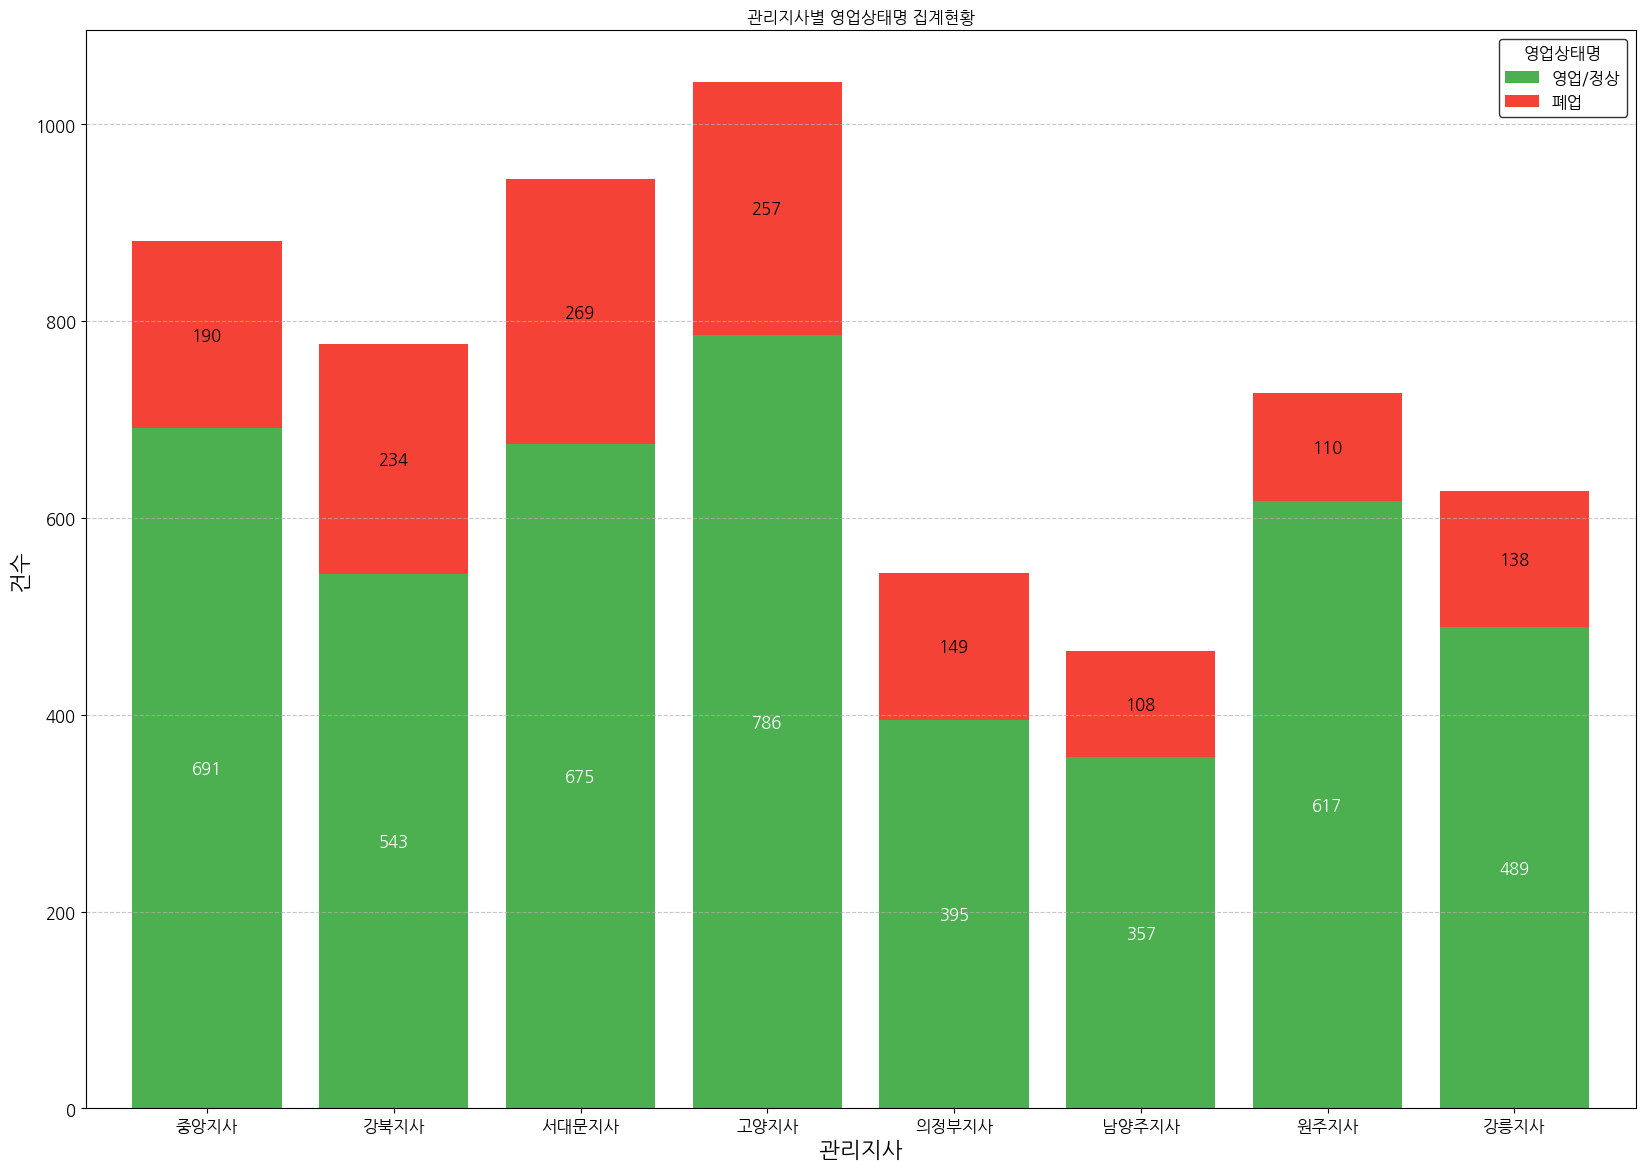

관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.png
PDF 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.pdf
HTML 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.html


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from google.colab import drive
from matplotlib.backends.backend_pdf import PdfPages

# mpld3 설치
!pip install mpld3
import mpld3

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# 'Unknown' 관리지사 및 SP담당 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 관리지사별로 집계
grouped_df = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reindex(desired_order)

# 관리지사별 현황표 생성
print("관리지사별 영업상태 현황표:")
print(grouped_df)

# 시각화 (막대 그래프)
fig, ax = plt.subplots(figsize=(20, 14))  # 그래프 크기를 크게 조정
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = grouped_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('관리지사별 영업상태명 집계현황', fontsize=22, fontproperties=fontprop)
ax.set_xlabel('관리지사', fontsize=16, fontproperties=fontprop)
ax.set_ylabel('건수', fontsize=16, fontproperties=fontprop)
plt.xticks(fontsize=14, fontproperties=fontprop, rotation=0, ha='center')  # 텍스트 수평 정렬
plt.yticks(fontsize=14, fontproperties=fontprop)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=12, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop, loc='upper right', frameon=True)
plt.setp(legend.get_title(), fontproperties=fontprop)

# 범례 배경과 테두리 설정
legend.get_frame().set_facecolor('white')  # 배경색
legend.get_frame().set_edgecolor('black')  # 테두리색

# 그래프에 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
fig_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 PDF로 저장
pdf_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.pdf')
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

# 그래프를 HTML로 저장
html_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.html')
mpld3.save_html(fig, html_path)

# 그래프를 출력
plt.show()

print(f"관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: {fig_path}")
print(f"PDF 파일로 저장되었습니다: {pdf_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

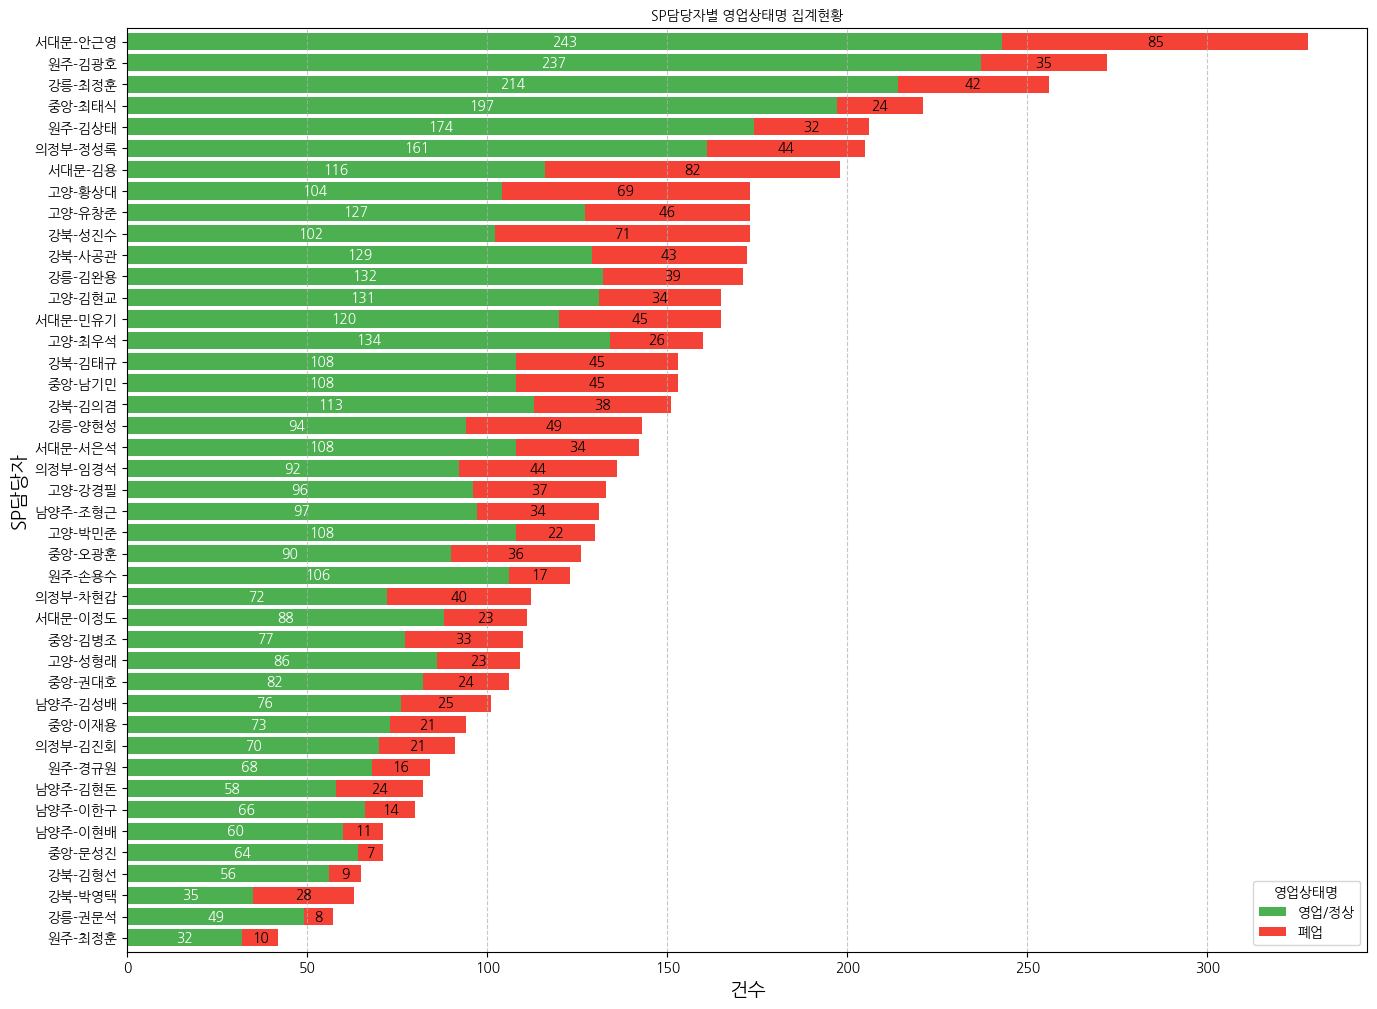

전체 영업상태명 집계현황 전문가 그래프가 생성되었습니다: /content/drive/My Drive/회사업무/인허가_0815/전체_영업상태명_집계현황_전문가_0814.png
PDF 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/전체_영업상태명_집계현황.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.font_manager as fm
from matplotlib.backends.backend_pdf import PdfPages
import os

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# '중앙' 지사 및 'Unknown' 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != '중앙') &
                                        (df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# 담당자 앞에 관리지사 이름 추가 (지사 제외)
df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=True).index]

# 시각화 (가로 막대 그래프)
fig, ax = plt.subplots(figsize=(16, 12))
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = status_counts.plot(kind='barh', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('SP담당자별 영업상태명 집계현황', fontsize=18, fontproperties=fontprop)
ax.set_xlabel('건수', fontsize=14, fontproperties=fontprop)
ax.set_ylabel('SP담당자', fontsize=14, fontproperties=fontprop)
plt.xticks(fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=10, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop, loc='lower right')
plt.setp(legend.get_title(), fontproperties=fontprop)

# 그래프에 그리드 추가
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
fig_path = os.path.join(output_dir, '전체_영업상태명_집계현황_전문가_0814.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 출력
plt.show()

print(f"전체 영업상태명 집계현황 전문가 그래프가 생성되었습니다: {fig_path}")

# 추가: PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')

with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

print(f"PDF 파일로 저장되었습니다: {pdf_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

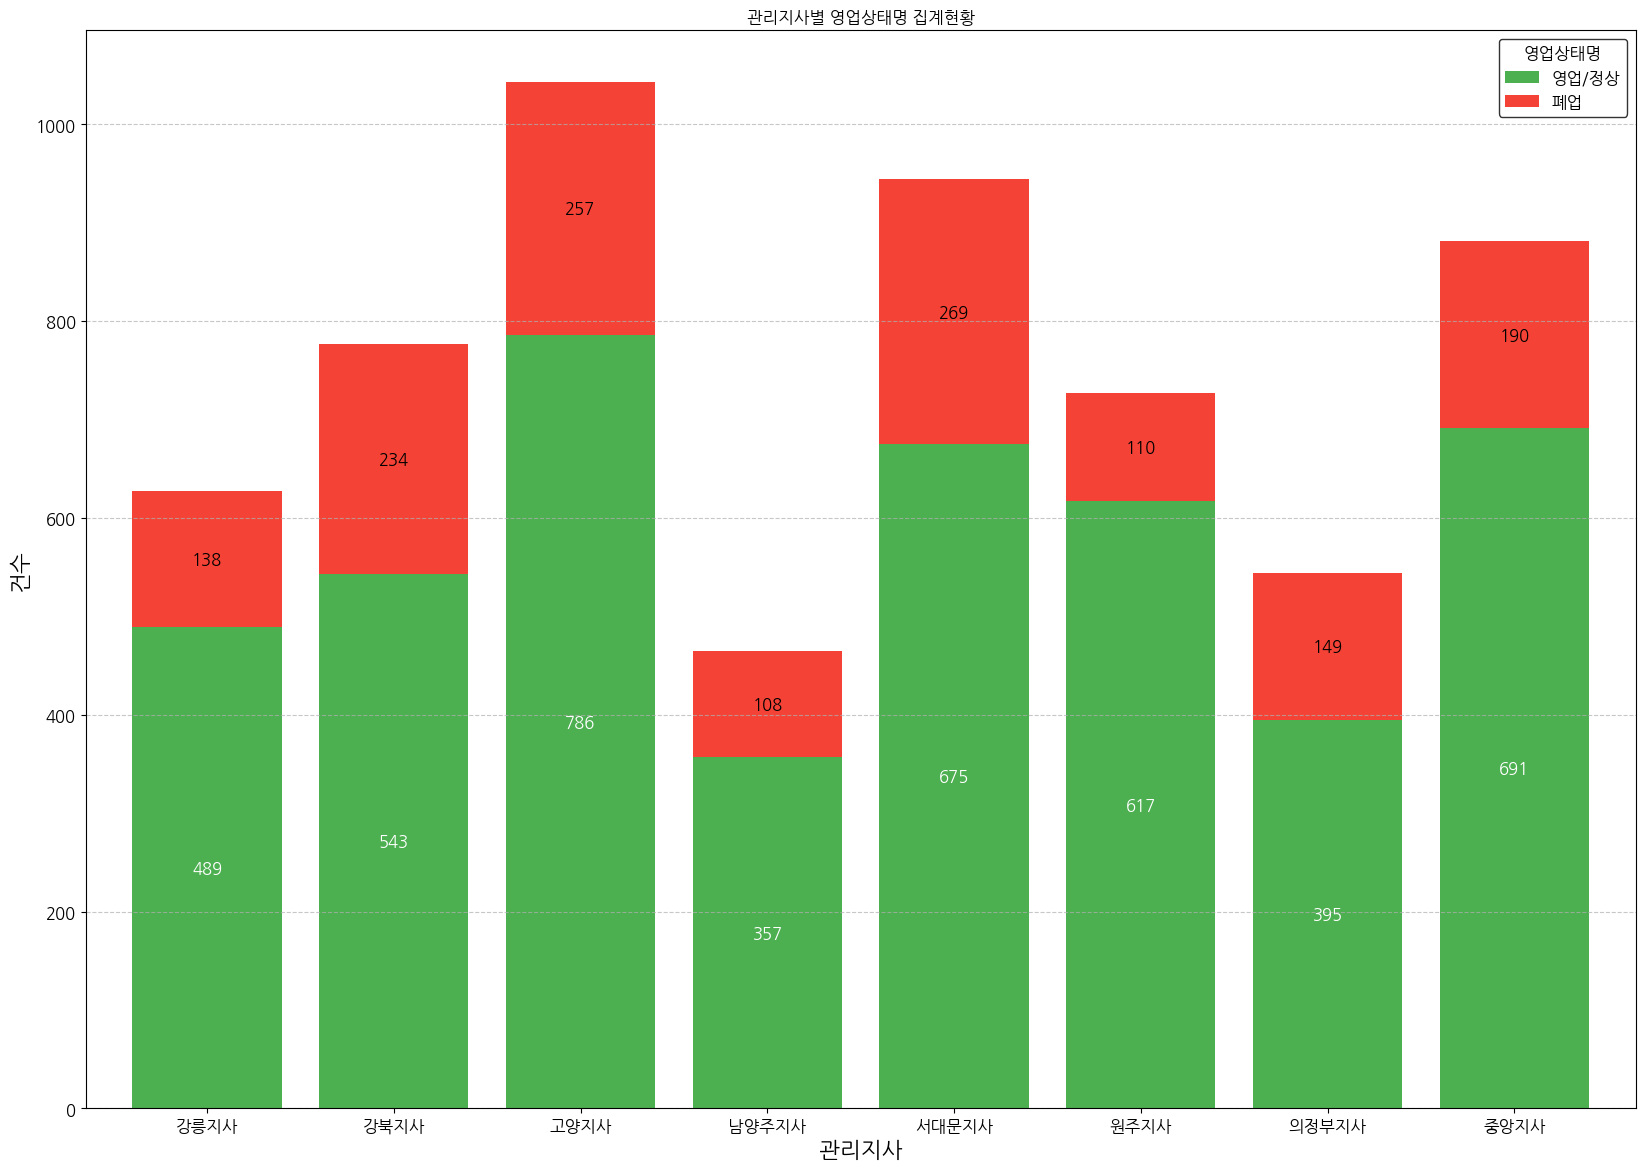

관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.png
PDF 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.pdf
HTML 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/관리지사별_영업상태명_집계현황_정렬.html


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from google.colab import drive
from matplotlib.backends.backend_pdf import PdfPages

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# 'Unknown' 관리지사 및 SP담당 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# SP담당자 필드 앞에 관리지사 이름 추가
df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당자'])

# 관리지사별로 집계 (SP담당자별 세분화 포함)
grouped_df = df_filtered_sorted.groupby(['관리지사', 'SP담당자', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reset_index().set_index('관리지사')
grouped_df = grouped_df.loc[desired_order].reset_index()

# 관리지사별 현황표 생성
print("관리지사별 영업상태 현황표 (SP담당자 포함):")
print(grouped_df)

# 시각화 (막대 그래프)
fig, ax = plt.subplots(figsize=(20, 14))  # 그래프 크기를 크게 조정
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = grouped_df.groupby('관리지사').sum().plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('관리지사별 영업상태명 집계현황', fontsize=22, fontproperties=fontprop)
ax.set_xlabel('관리지사', fontsize=16, fontproperties=fontprop)
ax.set_ylabel('건수', fontsize=16, fontproperties=fontprop)
plt.xticks(fontsize=14, fontproperties=fontprop, rotation=0, ha='center')  # 텍스트 수평 정렬
plt.yticks(fontsize=14, fontproperties=fontprop)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=12, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop, loc='upper right', frameon=True)
plt.setp(legend.get_title(), fontproperties=fontprop)

# 범례 배경과 테두리 설정
legend.get_frame().set_facecolor('white')  # 배경색
legend.get_frame().set_edgecolor('black')  # 테두리색

# 그래프에 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
fig_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 PDF로 저장
pdf_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.pdf')
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

# 그래프를 HTML로 저장 (이미지 삽입 방식)
html_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.html')
with open(html_path, 'w') as f:
    f.write(f'<img src="{fig_path}" alt="관리지사별 영업상태명 집계현황">')

# 그래프를 출력
plt.show()

print(f"관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: {fig_path}")
print(f"PDF 파일로 저장되었습니다: {pdf_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from google.colab import drive
from matplotlib.backends.backend_pdf import PdfPages

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=14)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# 'Unknown' 관리지사 및 SP담당 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# SP담당자 필드 앞에 관리지사 이름 추가
df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당자'])

# 관리지사별로 집계
grouped_df = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)

# SP담당자별로 집계
sp_grouped_df = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reindex(desired_order)

# PDF와 이미지 저장 경로 설정
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
pdf_path = os.path.join(output_dir, '통합_영업상태명_집계현황.pdf')
image_path = os.path.join(output_dir, '통합_영업상태명_집계현황.png')
html_path = os.path.join(output_dir, '통합_영업상태명_집계현황.html')

# PDF 저장
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(20, 14))
    grouped_df.plot(kind='bar', stacked=True, ax=ax1, color=['#4caf50', '#f44336'], width=0.7)
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=24, fontproperties=fontprop)
    ax1.set_xlabel('관리지사', fontsize=18, fontproperties=fontprop)
    ax1.set_ylabel('건수', fontsize=18, fontproperties=fontprop)
    plt.xticks(fontsize=16, fontproperties=fontprop, rotation=0, ha='center')
    plt.yticks(fontsize=16, fontproperties=fontprop)

    # 막대에 숫자 표시
    for container in ax1.containers:
        ax1.bar_label(container, label_type='center', fontsize=14, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

    # 범례 설정
    handles, labels = ax1.get_legend_handles_labels()
    legend = ax1.legend(handles, labels, title='영업상태명', fontsize=14, title_fontsize='16', prop=fontprop, loc='upper right', frameon=True)
    plt.setp(legend.get_title(), fontproperties=fontprop)

    # 그래프에 그리드 추가
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    fig2, ax2 = plt.subplots(figsize=(20, 20))
    sp_grouped_df.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'], width=0.7)
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=24, fontproperties=fontprop)
    ax2.set_xlabel('건수', fontsize=18, fontproperties=fontprop)
    ax2.set_ylabel('SP담당자', fontsize=18, fontproperties=fontprop)
    plt.xticks(fontsize=16, fontproperties=fontprop)
    plt.yticks(fontsize=16, fontproperties=fontprop)

    # 막대에 숫자 표시
    for container in ax2.containers:
        ax2.bar_label(container, label_type='center', fontsize=14, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

    # 범례 설정
    handles, labels = ax2.get_legend_handles_labels()
    legend = ax2.legend(handles, labels, title='영업상태명', fontsize=14, title_fontsize='16', prop=fontprop, loc='lower right', frameon=True)
    plt.setp(legend.get_title(), fontproperties=fontprop)

    # 그래프에 그리드 추가
    ax2.grid(True, axis='x', linestyle='--', alpha=0.7)
    pdf.savefig(fig2)
    plt.close(fig2)

# PNG 이미지로 저장 (SP담당자 포함)
fig_combined, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 35))

# 시각화 1: 관리지사별 영업상태명 집계현황
grouped_df.plot(kind='bar', stacked=True, ax=ax1, color=['#4caf50', '#f44336'], width=0.7)
ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=24, fontproperties=fontprop)
ax1.set_xlabel('관리지사', fontsize=18, fontproperties=fontprop)
ax1.set_ylabel('건수', fontsize=18, fontproperties=fontprop)
ax1.legend(title='영업상태명', fontsize=14, title_fontsize='16', prop=fontprop, loc='upper right', frameon=True)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# 막대에 숫자 표시
for container in ax1.containers:
    ax1.bar_label(container, label_type='center', fontsize=14, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 시각화 2: SP담당자별 영업상태명 집계현황
sp_grouped_df.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'], width=0.7)
ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=24, fontproperties=fontprop)
ax2.set_xlabel('건수', fontsize=18, fontproperties=fontprop)
ax2.set_ylabel('SP담당자', fontsize=18, fontproperties=fontprop)
ax2.legend(title='영업상태명', fontsize=14, title_fontsize='16', prop=fontprop, loc='lower right', frameon=True)
ax2.grid(True, axis='x', linestyle='--', alpha=0.7)

# 막대에 숫자 표시
for container in ax2.containers:
    ax2.bar_label(container, label_type='center', fontsize=14, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# PNG 이미지 저장
plt.tight_layout()
fig_combined.savefig(image_path, bbox_inches='tight')
plt.close(fig_combined)

# HTML 파일로 저장
with open(html_path, 'w') as f:
    f.write(f'<img src="{image_path}" alt="통합 영업상태명 집계현황">')

print(f"통합된 영업상태명 집계현황 그래프가 생성되었습니다: {pdf_path}")
print(f"PNG 파일로 저장되었습니다: {image_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,536 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 50521 (\N{HANGUL SYLLABLE ANG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  plt.tight_layout()
<ipython-input-1-30f82d1627ca>:135: UserWarning: Glyph 

통합된 영업상태명 집계현황 그래프가 생성되었습니다: /content/drive/My Drive/회사업무/인허가_0815/통합_영업상태명_집계현황.pdf
PNG 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/통합_영업상태명_집계현황.png
HTML 파일로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/통합_영업상태명_집계현황.html


In [1]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.3 MB/s eta 0:00:00


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,153 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()



기술 통계:
        네이버 지도 링크  관리지사  SP담당  사업장명 개방서비스명 업태구분명            평수  \
count        6077  6077  6077  6077   6077  5001   4445.000000   
unique          1     8    42  5643     99   193           NaN   
top     네이버 지도 보기  고양지사   안근영  유농위드  일반음식점    한식           NaN   
freq         6077  1059   328    10   1823   793           NaN   
mean          NaN   NaN   NaN   NaN    NaN   NaN    117.699512   
std           NaN   NaN   NaN   NaN    NaN   NaN   1127.649752   
min           NaN   NaN   NaN   NaN    NaN   NaN      0.000000   
25%           NaN   NaN   NaN   NaN    NaN   NaN      7.140000   
50%           NaN   NaN   NaN   NaN    NaN   NaN     16.990000   
75%           NaN   NaN   NaN   NaN    NaN   NaN     40.900000   
max           NaN   NaN   NaN   NaN    NaN   NaN  34118.040000   

                         소재지전체주소                                도로명전체주소  \
count                       6077                                   5884   
unique                      5218                 

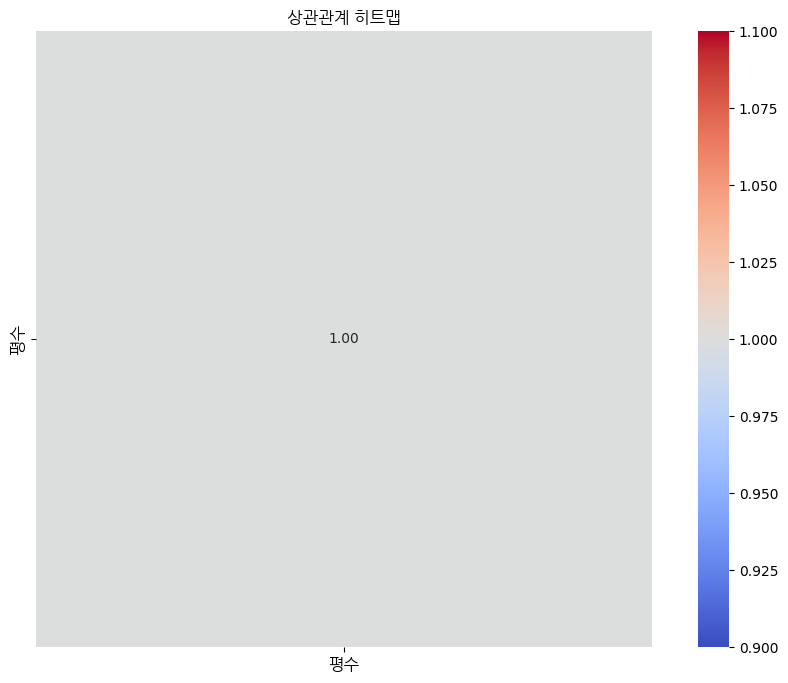

EDA 결과가 /content/drive/My Drive/회사업무/인허가_0815/EDA_결과.xlsx에 저장되었습니다.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import matplotlib.font_manager as fm
import os

# 필요한 패키지 설치
!pip install xlsxwriter

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):  # os 모듈을 사용하여 파일이 존재하는지 확인합니다.
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df = pd.read_excel(file_path)

# 'Unknown' 제외
df = df[(df['관리지사'] != 'Unknown') & (df['SP담당'] != 'Unknown')]

# 간단한 기술 통계 출력
print("\n기술 통계:")
print(df.describe(include='all'))

# 결측치 분석
missing_values = df.isnull().sum()
print("\n결측치 분석 (결측치가 있는 열만 표시):")
print(missing_values[missing_values > 0])

# 수치형 데이터만 선택하여 상관관계 분석
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('상관관계 히트맵', fontsize=16, fontproperties=fontprop)
plt.xticks(fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)
plt.show()

# EDA 결과를 엑셀 파일로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
os.makedirs(output_dir, exist_ok=True)
eda_results_path = os.path.join(output_dir, 'EDA_결과.xlsx')

with pd.ExcelWriter(eda_results_path, engine='xlsxwriter') as writer:
    df.describe(include='all').to_excel(writer, sheet_name='기술통계')
    missing_values.to_frame(name='결측치').to_excel(writer, sheet_name='결측치 분석')

print(f"EDA 결과가 {eda_results_path}에 저장되었습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.6 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/sha

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


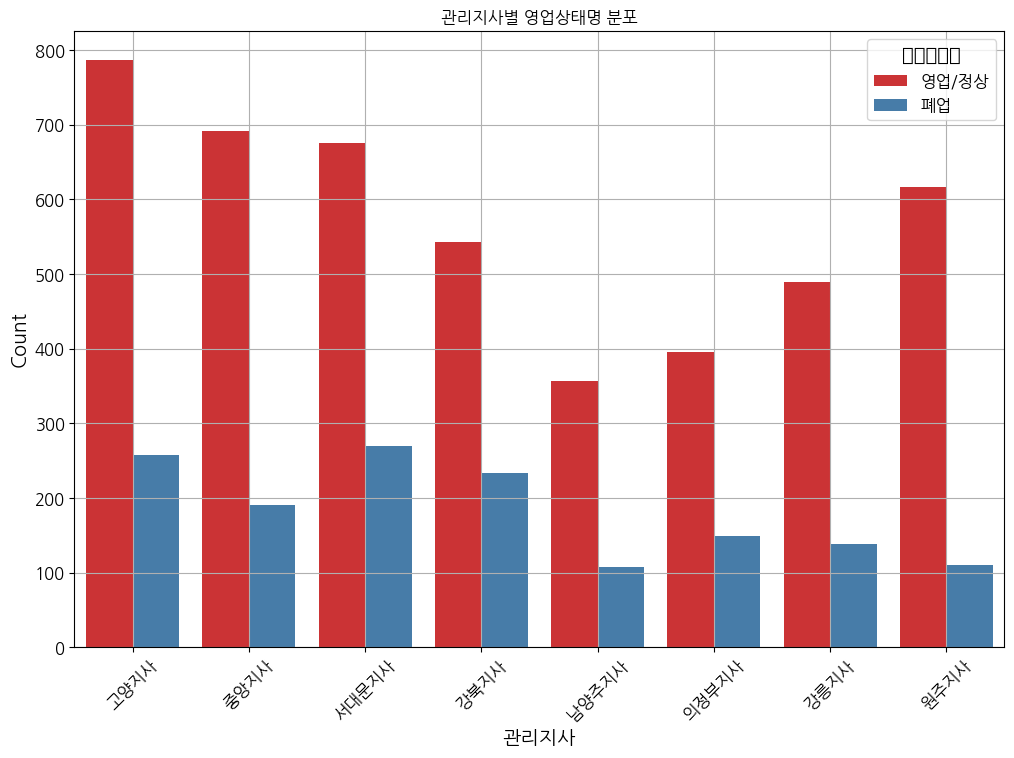

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


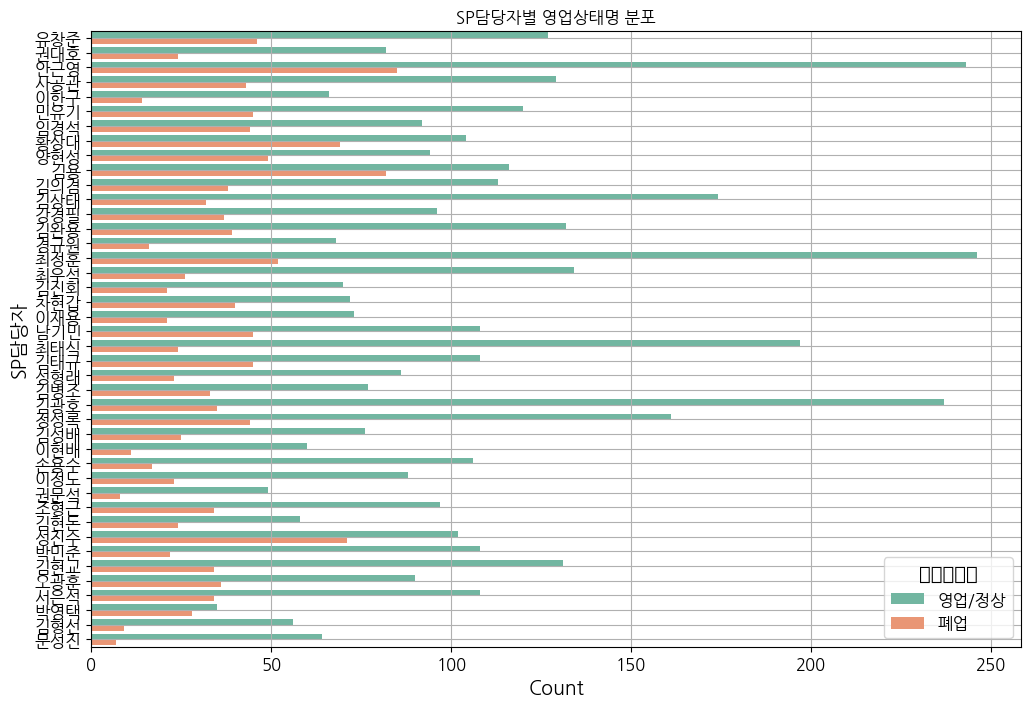

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()


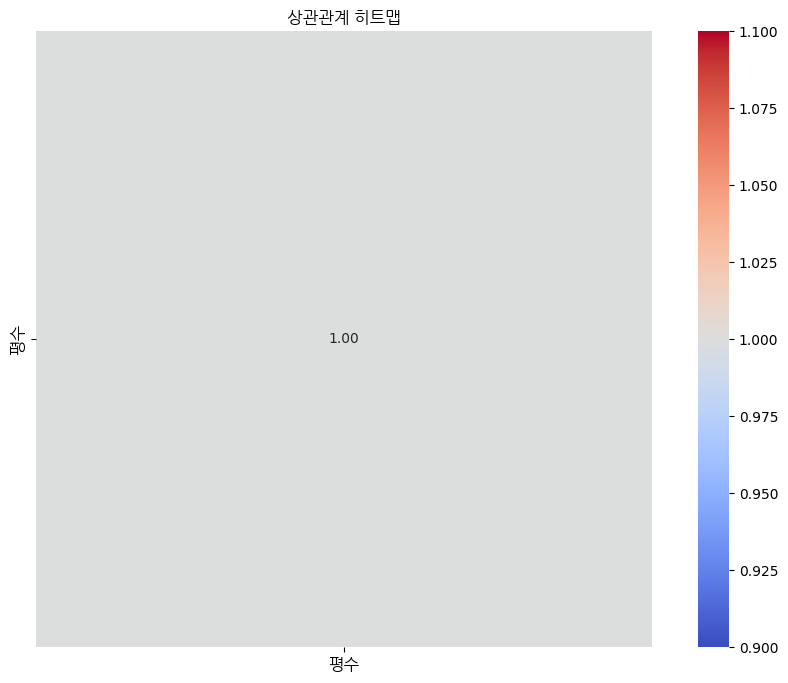

EDA 결과가 /content/drive/My Drive/회사업무/인허가_0815/EDA_결과.xlsx에 저장되었습니다.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import matplotlib.font_manager as fm
import os

# 필요한 패키지 설치
!pip install xlsxwriter

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):  # os 모듈을 사용하여 파일이 존재하는지 확인합니다.
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df = pd.read_excel(file_path)

# 'Unknown' 값 제외 및 '영업/정상', '폐업' 상태만 포함
df = df[(df['관리지사'] != 'Unknown') &
        (df['SP담당'] != 'Unknown') &
        (df['영업상태명'].isin(['영업/정상', '폐업']))]

# 간단한 기술 통계 출력
print("\n기술 통계:")
print(df.describe(include='all'))

# 결측치 분석
missing_values = df.isnull().sum()
print("\n결측치 분석 (결측치가 있는 열만 표시):")
print(missing_values[missing_values > 0])

# 관리지사별 영업상태 분석
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='관리지사', hue='영업상태명', palette='Set1')
plt.title('관리지사별 영업상태명 분포', fontsize=16, fontproperties=fontprop)
plt.xlabel('관리지사', fontsize=14, fontproperties=fontprop)
plt.ylabel('Count', fontsize=14, fontproperties=fontprop)
plt.xticks(rotation=45, fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)
plt.legend(title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop)
plt.grid(True)
plt.show()

# SP담당자별 영업상태 분석
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='SP담당', hue='영업상태명', palette='Set2')
plt.title('SP담당자별 영업상태명 분포', fontsize=16, fontproperties=fontprop)
plt.xlabel('Count', fontsize=14, fontproperties=fontprop)
plt.ylabel('SP담당자', fontsize=14, fontproperties=fontprop)
plt.xticks(fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)
plt.legend(title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop)
plt.grid(True)
plt.show()

# 수치형 데이터만 선택하여 상관관계 분석
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('상관관계 히트맵', fontsize=16, fontproperties=fontprop)
plt.xticks(fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)
plt.show()

# EDA 결과를 엑셀 파일로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
os.makedirs(output_dir, exist_ok=True)
eda_results_path = os.path.join(output_dir, 'EDA_결과.xlsx')

with pd.ExcelWriter(eda_results_path, engine='xlsxwriter') as writer:
    df.describe(include='all').to_excel(writer, sheet_name='기술통계')
    missing_values.to_frame(name='결측치').to_excel(writer, sheet_name='결측치 분석')

print(f"EDA 결과가 {eda_results_path}에 저장되었습니다.")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import matplotlib.font_manager as fm
import os
from matplotlib.backends.backend_pdf import PdfPages

# 필요한 패키지 설치
!pip install xlsxwriter

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):  # os 모듈을 사용하여 파일이 존재하는지 확인합니다.
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df = pd.read_excel(file_path)

# 'Unknown' 값 제외 및 '영업/정상', '폐업' 상태만 포함
df = df[(df['관리지사'] != 'Unknown') &
        (df['SP담당'] != 'Unknown') &
        (df['영업상태명'].isin(['영업/정상', '폐업']))]

# EDA 결과 시각화 저장 경로 설정
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
os.makedirs(output_dir, exist_ok=True)
pdf_path = os.path.join(output_dir, 'EDA_결과.pdf')
html_path = os.path.join(output_dir, 'EDA_결과.html')

# PDF 파일 생성
with PdfPages(pdf_path) as pdf:

    # 관리지사별 영업상태 분석 시각화
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    sns.countplot(data=df, x='관리지사', hue='영업상태명', palette='Set1', ax=ax1)
    ax1.set_title('관리지사별 영업상태명 분포', fontsize=16, fontproperties=fontprop)
    ax1.set_xlabel('관리지사', fontsize=14, fontproperties=fontprop)
    ax1.set_ylabel('Count', fontsize=14, fontproperties=fontprop)
    ax1.legend(title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop)
    plt.xticks(rotation=45, fontsize=12, fontproperties=fontprop)
    plt.yticks(fontsize=12, fontproperties=fontprop)
    plt.grid(True)
    pdf.savefig(fig1)
    plt.savefig(os.path.join(output_dir, '관리지사별_영업상태명.png'))
    plt.close(fig1)

    # SP담당자별 영업상태 분석 시각화
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    sns.countplot(data=df, y='SP담당', hue='영업상태명', palette='Set2', ax=ax2)
    ax2.set_title('SP담당자별 영업상태명 분포', fontsize=16, fontproperties=fontprop)
    ax2.set_xlabel('Count', fontsize=14, fontproperties=fontprop)
    ax2.set_ylabel('SP담당자', fontsize=14, fontproperties=fontprop)
    ax2.legend(title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop)
    plt.xticks(fontsize=12, fontproperties=fontprop)
    plt.yticks(fontsize=12, fontproperties=fontprop)
    plt.grid(True)
    pdf.savefig(fig2)
    plt.savefig(os.path.join(output_dir, 'SP담당자별_영업상태명.png'))
    plt.close(fig2)

    # 상관관계 분석 시각화
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    fig3, ax3 = plt.subplots(figsize=(12, 8))
    correlation = numeric_df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True, ax=ax3)
    ax3.set_title('상관관계 히트맵', fontsize=16, fontproperties=fontprop)
    plt.xticks(fontsize=12, fontproperties=fontprop)
    plt.yticks(fontsize=12, fontproperties=fontprop)
    pdf.savefig(fig3)
    plt.savefig(os.path.join(output_dir, '상관관계_히트맵.png'))
    plt.close(fig3)

# HTML 파일 생성
with open(html_path, 'w') as f:
    f.write('<html><head><title>EDA 결과</title></head><body>')
    f.write('<h1>관리지사별 영업상태명 분포</h1>')
    f.write('<img src="관리지사별_영업상태명.png" width="800">')
    f.write('<h1>SP담당자별 영업상태명 분포</h1>')
    f.write('<img src="SP담당자별_영업상태명.png" width="800">')
    f.write('<h1>상관관계 히트맵</h1>')
    f.write('<img src="상관관계_히트맵.png" width="800">')
    f.write('</body></html>')

print(f"EDA 결과가 PDF로 저장되었습니다: {pdf_path}")
print(f"EDA 결과가 HTML로 저장되었습니다: {html_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,858 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/sh

<ipython-input-1-34ff8052d35b>:58: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  pdf.savefig(fig1)
<ipython-input-1-34ff8052d35b>:58: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  pdf.savefig(fig1)
<ipython-input-1-34ff8052d35b>:58: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  pdf.savefig(fig1)
<ipython-input-1-34ff8052d35b>:58: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  pdf.savefig(fig1)
<ipython-input-1-34ff8052d35b>:58: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  pdf.savefig(fig1)
<ipython-input-1-34ff8052d35b>:59: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  plt.savefig(os.path.join(output_dir, '관리지사별_영업상태명.png'))
<ipython-input-1-34ff8052d35b>:59: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.savefig(os.path.join(output_dir, '관리

EDA 결과가 PDF로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/EDA_결과.pdf
EDA 결과가 HTML로 저장되었습니다: /content/drive/My Drive/회사업무/인허가_0815/EDA_결과.html
